<a href="https://colab.research.google.com/github/cosmo3769/reinforcement_learning/blob/master/Q_Learning_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Imports

In [1]:
# Check if the notebook is running on colab or not.
try:
    import google.colab
    COLAB = True
except:
    COLAB = False
print(f'Is the notebook using colab environment: {COLAB}')

if COLAB:
    # Install W&B for MLOPs.
    print(f'Installing Weights and Biases')
    !pip install -qq --upgrade wandb
    # Install gymnasium
    print(f'Installing gymnasium')
    !pip install -qq gymnasium

Is the notebook using colab environment: True
Installing Weights and Biases
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
Installing gymnasium
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.9 MB/s eta 0:00:00


In [ ]:
# Login to your W&B account.
import wandb
wandb.login()

In [2]:
import os
import tqdm
import random
import imageio
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

from argparse import Namespace
from tqdm.notebook import tqdm

# Initializing env

In [3]:
env = gym.make('CliffWalking-v0', render_mode="rgb_array")

# Observation Space

In [4]:
print("------OBSERVATION SPACE------ \n")
print("Observation Space =", env.observation_space)
print("Sample observation =", env.observation_space.sample()) # Get a random observation

------OBSERVATION SPACE------ 

Observation Space = Discrete(48)
Sample observation = 0


# Action Space

In [5]:
print("------ACTION SPACE------ \n")
print("Action Space =", env.action_space.n)
print("Sample action =", env.action_space.sample()) # Take a random action

------ACTION SPACE------ 

Action Space = 4
Sample action = 1


# Observing the environment

In [6]:
state, info = env.reset()

In [7]:
state

36

In [8]:
info

{'prob': 1}

# Executing an action

In [9]:
action = env.action_space.sample()
print("Action taken =", action)

state, info = env.reset()
print("Initial State =", state)

new_state, reward, terminated, truncated, info = env.step(action)
print("State reached after taking an action =", new_state)
print("Reward recieved after taking an action =", reward)
print("terminated =", terminated)
print("truncated =", truncated)
print("info =", info)

Action taken = 0
Initial State = 36
State reached after taking an action = 24
Reward recieved after taking an action = -1
terminated = False
truncated = False
info = {'prob': 1.0}


# Initializing Q-table

In [10]:
state_space = env.observation_space.n
print("There are", state_space, "possible states")

action_space = env.action_space.n
print("There are", action_space, "possible actions")

There are 48 possible states
There are 4 possible actions


In [11]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

In [12]:
Qtable_cliffwalking = initialize_q_table(state_space, action_space)

In [13]:
Qtable_cliffwalking

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],


# Build the agent

In [14]:
class CliffwalkingAgent:
    def __init__(self, args):
        self.args = args

    def get_action(
        self,
        Qtable,
        state,
        epsilon
    ):
        if np.random.random() > epsilon:
            return np.argmax(Qtable[state][:])
        else:
            return env.action_space.sample()

    def update(
        self,
        Qtable,
        state,
        new_state,
        action
    ):
        return Qtable[state][action] + self.args.learning_rate * (reward + self.args.discount_factor * np.max(Qtable[new_state]) - Qtable[state][action])

    def decay_epsilon(
        self,
        episode
    ):
        return self.args.min_epsilon + (self.args.max_epsilon - self.args.min_epsilon)*np.exp(-self.args.decay_rate*episode)

In [14]:
class CliffwalkingAgent:
    def __init__(self, args):
        self.args = args
        self.training_error = []

    def get_action(
        self,
        Qtable,
        state,
        epsilon
    ):
        if np.random.random() > epsilon:
            return np.argmax(Qtable[state][:])
        else:
            return env.action_space.sample()

    def update(
        self,
        Qtable,
        state,
        new_state,
        action
    ):
        td_target = reward + self.args.discount_factor * np.max(Qtable[new_state])
        td_error = td_target - Qtable[state][action]
        self.training_error.append(td_error)
        return Qtable[state][action] + self.args.learning_rate * td_error

    def decay_epsilon(
        self,
        episode
    ):
        exp_decay = np.exp(-self.args.decay_rate * episode)
        return self.args.min_epsilon + (self.args.max_epsilon - self.args.min_epsilon) * exp_decay

# Hyperparameters

In [15]:
configs = Namespace(
    # Training parameters
    n_training_episodes = 100000,  # Total training episodes
    learning_rate = 0.7,          # Learning rate

    # Evaluation parameters
    n_eval_episodes = 100,        # Total number of test episodes

    # Environment parameters
    env_id = "CliffWalking-v0",     # Name of the environment
    max_steps = 99,               # Max steps per episode
    discount_factor = 0.95,                 # Discounting rate
    eval_seed = [],               # The evaluation seed of the environment

    # Exploration parameters
    max_epsilon = 1.0,             # Exploration probability at start
    min_epsilon = 0.05,            # Minimum exploration probability
    decay_rate = 0.0005,            # Exponential decay rate for exploration prob
)

# Training Loop

In [16]:
agent = CliffwalkingAgent(configs)

In [17]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=configs.n_training_episodes)

def train(n_training_episodes, max_steps, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = agent.decay_epsilon(episode)
        # Reset the environment
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        # repeat
        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = agent.get_action(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = agent.update(Qtable, state, new_state, action)

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break

            # Our next state is the new state
            state = new_state

    return Qtable

In [18]:
Qtable_cliffwalking = train(configs.n_training_episodes, configs.max_steps, Qtable_cliffwalking)

  0%|          | 0/100000 [00:00<?, ?it/s]

# Updated Q-values

In [19]:
Qtable_cliffwalking

array([[-10.7341754 , -10.24650042, -10.24650042, -10.7341754 ],
       [-10.24650042,  -9.73315833,  -9.73315833, -10.7341754 ],
       [ -9.73315833,  -9.19279825,  -9.19279825, -10.24650042],
       [ -9.19279825,  -8.62399815,  -8.62399815,  -9.73315833],
       [ -8.62399815,  -8.02526122,  -8.02526122,  -9.19279825],
       [ -8.02526122,  -7.39501181,  -7.39501181,  -8.62399815],
       [ -7.39501181,  -6.73159137,  -6.73159137,  -8.02526122],
       [ -6.73159137,  -6.03325408,  -6.03325408,  -7.39501181],
       [ -6.03325408,  -5.29816219,  -5.29816219,  -6.73159137],
       [ -5.29816219,  -4.52438125,  -4.52438125,  -6.03325408],
       [ -4.52438125,  -3.709875  ,  -3.709875  ,  -5.29816219],
       [ -3.709875  ,  -3.709875  ,  -2.8525    ,  -4.52438125],
       [-10.7341754 ,  -9.73315833,  -9.73315833, -10.24650042],
       [-10.24650042,  -9.19279825,  -9.19279825, -10.24650042],
       [ -9.73315833,  -8.62399815,  -8.62399815,  -9.73315833],
       [ -9.19279825,  -8

# Visualization

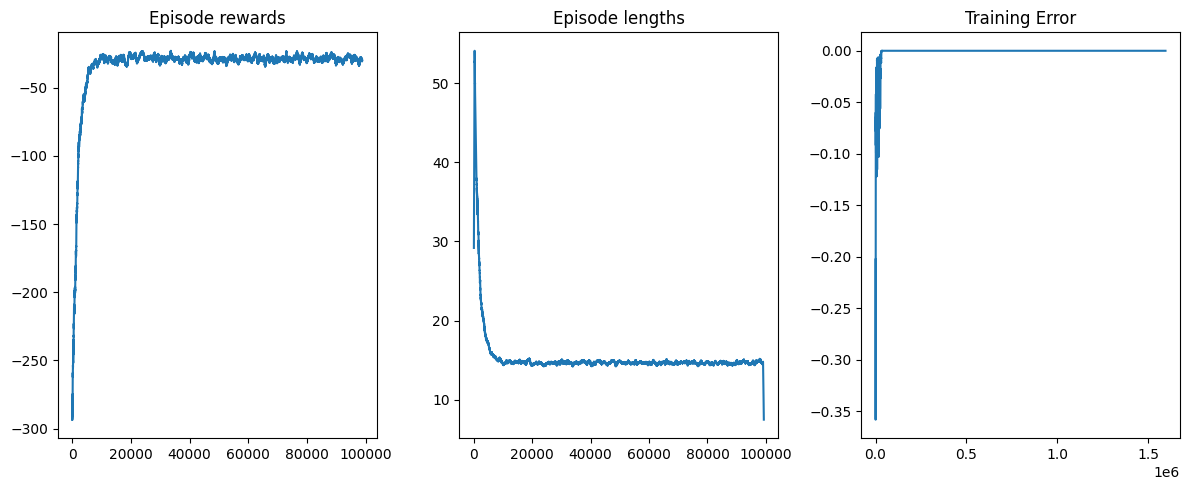

In [25]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [ ]:
rolling_length = 500
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
wandb.log({'episode reward over time': reward_moving_average})

length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
wandb.log({'episode length over time': length_moving_average})

training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
wandb.log({'training error': training_error_moving_average})

# Evaluate trained Agent

In [26]:
def evaluate_agent(env, max_steps, n_eval_episodes, Qtable, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for cliffwalking)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state, info = env.reset(seed=seed[episode])
    else:
      state, info = env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Qtable[state][:])
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [27]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, configs.max_steps, configs.n_eval_episodes, Qtable_cliffwalking, configs.eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=-13.00 +/- 0.00


# Record Video of Optimal Policy

In [19]:
def record_video(env, Qtable, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [20]:
video_path = "replay.mp4"
record_video(env, Qtable_cliffwalking, video_path, fps=1)

# Log video to wandb